**Goal**: this notebooks downloads the dataset of all files obtained via github search. We aim at iteratively filter the dataset to remove low-quality data and pinpoint only files which are actual code written by quantum developers.

# Dataset of Quantum Program - v01

In [3]:
import project_path
from rdlib import *  # this imports the base libraries\

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
RAW_FILES_FOLDER = '../data/00_program_data_raw/exp_v01'
DATASET_OUTPUT_FOLDER = '../data/01_program_data_compressed/exp_v01'
PROGRAMS_FOLDER = '../data/02_programs/exp_v01/'
FILTERED_PROGRAMS_FOLDER = '../data/03_program_filtered/exp_v01/code_only_programs'
PATH_TO_DEDUP_DICT = '../data/03_program_filtered/exp_v01/dedup.json'

DIR_FINAL_DATASET = '../data/04_program_under_study/exp_v01'
PATH_COMPRESSED_FINAL_DATASET = '../data/04_program_under_study/exp_v01_program_dataset.csv'

DIR_W_CIRCUIT = '../data/05_program_w_quantum_circuit/exp_v01/'

# Create Dataset of URLs from Github Search
Each records contains the info of a file found via github search. 

In [ ]:
from rdlib.fsh import read_data_in_parallel
from rdlib.fsh import read_json_file
import hashlib

# read all the json files
files = read_data_in_parallel(
    base_folder=RAW_FILES_FOLDER,
    file_type_regex='files_.*\.json', 
    read_function=read_json_file,
    n_processes=10)
flat_files = [item for sublist in files for item in sublist]
df_dataset = pd.DataFrame.from_records(flat_files)

# derive the download_url from the html_url
df_dataset['download_url'] = df_dataset['html_url'].apply(
    lambda x: x.replace(
        'https://github.com/', 
        'https://raw.githubusercontent.com/').replace('/blob/', '/'))

# drop duplicates
df_dataset.drop_duplicates(subset=['download_url'], inplace=True)
# drop forks
df_dataset = df_dataset[df_dataset['repository_fork'] == False]
# extract filename from the downalod_url
df_dataset['filename'] = df_dataset['download_url'].apply(
    lambda x: x.split('/')[-1])
# add artificail extension to filenames without a dot
df_dataset['filename'] = df_dataset['filename'].apply(
    lambda x: x if '.' in x else x + '.no_ext')
# extension
df_dataset['extension'] = df_dataset['filename'].apply(
    lambda x: x.split('.')[-1])
# filestem
df_dataset['filestem'] = df_dataset['filename'].apply(\
    lambda x: '.'.join(x.split('.')[:-1]))
# add hash of the download_url as a unique identifier
df_dataset['hash'] = df_dataset['download_url'].apply(
    lambda x: hashlib.sha256(x.encode('utf-8')).hexdigest()[:6])
# unique_id = filestem + hash + extension
df_dataset['unique_id'] = df_dataset['filestem'] + '_' + df_dataset['hash'] + '.' + df_dataset['extension']

df_dataset.head()


,download_url,html_url,name,path,repository_description,repository_fork,repository_name,repository_owner_url,repository_url,score,filename,extension,filestem,hash,unique_id
0,https://raw.githubusercontent.com/rupeshknn/pu...,https://github.com/rupeshknn/pulse-backend-qam...,pulse_backend.py,pulse_backend.py,Developing a backend-sim in Qiskit Experiments...,False,rupeshknn/pulse-backend-qamp22,https://github.com/rupeshknn/pulse-backend-qamp22,https://github.com/rupeshknn/pulse-backend-qamp22,1.0,pulse_backend.py,py,pulse_backend,e6a336,pulse_backend_e6a336.py
1,https://raw.githubusercontent.com/CQCL/tket_be...,https://github.com/CQCL/tket_benchmarking/blob...,chemistry_set_generator.py,arxiv-1902-08091/ChemistrySet/chemistry_set_ge...,Scripts and circuits for benchmarking tket,False,CQCL/tket_benchmarking,https://github.com/CQCL/tket_benchmarking,https://github.com/CQCL/tket_benchmarking,1.0,chemistry_set_generator.py,py,chemistry_set_generator,3e40eb,chemistry_set_generator_3e40eb.py
2,https://raw.githubusercontent.com/dlyongemallo...,https://github.com/dlyongemallo/quantum-comput...,teleport.py,qiskit/teleport.py,Tools for quantum computation,False,dlyongemallo/quantum-computation,https://github.com/dlyongemallo/quantum-comput...,https://github.com/dlyongemallo/quantum-comput...,1.0,teleport.py,py,teleport,6c481d,teleport_6c481d.py
3,https://raw.githubusercontent.com/bnbsking/Qua...,https://github.com/bnbsking/Quantum-Linear-Sys...,(True) No operation and Bell state,(True) No operation and Bell state,Simulator and Real quantum computer by Python....,False,bnbsking/Quantum-Linear-System-Algorithm,https://github.com/bnbsking/Quantum-Linear-Sys...,https://github.com/bnbsking/Quantum-Linear-Sys...,1.0,(True)%20No%20operation%20and%20Bell%20state.n...,no_ext,(True)%20No%20operation%20and%20Bell%20state,0d0b4e,(True)%20No%20operation%20and%20Bell%20state_0...
4,https://raw.githubusercontent.com/mtreinish/vf...,https://github.com/mtreinish/vf2_partial_layou...,plugin.py,vf2_partial_layout/plugin.py,An experimental Layout Pass for Qiskit's compiler,False,mtreinish/vf2_partial_layout,https://github.com/mtreinish/vf2_partial_layout,https://github.com/mtreinish/vf2_partial_layout,1.0,plugin.py,py,plugin,1c8fd5,plugin_1c8fd5.py


In [ ]:
df_dataset.to_csv(os.path.join(DATASET_OUTPUT_FOLDER, 'dataset.csv'), index=False)

# Dataset Characteristics

<AxesSubplot: xlabel='count', ylabel='extension'>

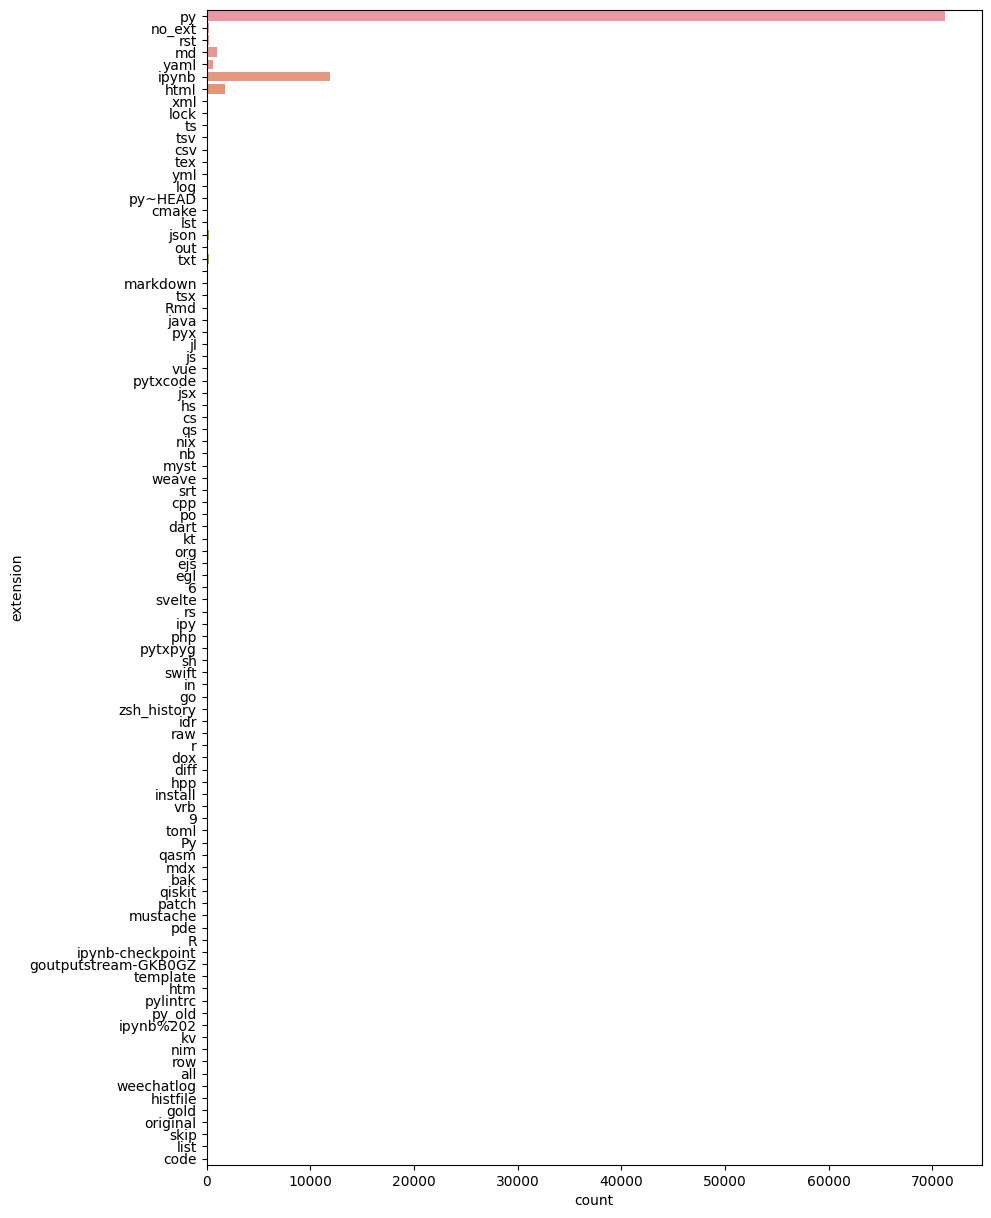

In [ ]:
fig, ax = plt.subplots(figsize=(10, 15))
sns.countplot(
    data=df_dataset,
    y='extension',
)

# Download Original Programs

In [ ]:
from rdlib.datalake import extract_url_hash_filename
from rdlib.datalake import download_files

url_snippets_to_download = df_dataset['download_url'].tolist()
download_files(
    urls=url_snippets_to_download,
    out_folder=PROGRAMS_FOLDER,
    func_url_to_filename=extract_url_hash_filename,
)

# Read Dataset

In [5]:
df_dataset = pd.read_csv(os.path.join(DATASET_OUTPUT_FOLDER, 'dataset.csv'))
# concatenate unique_id and extension
df_dataset['output_file_name'] = df_dataset['unique_id'] + '.' + df_dataset['extension']
df_dataset.head()

,download_url,html_url,name,path,repository_description,repository_fork,repository_name,repository_owner_url,repository_url,score,hash,filename,extension,filestem,unique_id,output_file_name
0,https://raw.githubusercontent.com/rupeshknn/pu...,https://github.com/rupeshknn/pulse-backend-qam...,pulse_backend.py,pulse_backend.py,Developing a backend-sim in Qiskit Experiments...,False,rupeshknn/pulse-backend-qamp22,https://github.com/rupeshknn/pulse-backend-qamp22,https://github.com/rupeshknn/pulse-backend-qamp22,1.0,e6a336,pulse_backend.py,py,pulse_backend,pulse_backend_e6a336,pulse_backend_e6a336.py
1,https://raw.githubusercontent.com/CQCL/tket_be...,https://github.com/CQCL/tket_benchmarking/blob...,chemistry_set_generator.py,arxiv-1902-08091/ChemistrySet/chemistry_set_ge...,Scripts and circuits for benchmarking tket,False,CQCL/tket_benchmarking,https://github.com/CQCL/tket_benchmarking,https://github.com/CQCL/tket_benchmarking,1.0,3e40eb,chemistry_set_generator.py,py,chemistry_set_generator,chemistry_set_generator_3e40eb,chemistry_set_generator_3e40eb.py
2,https://raw.githubusercontent.com/dlyongemallo...,https://github.com/dlyongemallo/quantum-comput...,teleport.py,qiskit/teleport.py,Tools for quantum computation,False,dlyongemallo/quantum-computation,https://github.com/dlyongemallo/quantum-comput...,https://github.com/dlyongemallo/quantum-comput...,1.0,6c481d,teleport.py,py,teleport,teleport_6c481d,teleport_6c481d.py
3,https://raw.githubusercontent.com/bnbsking/Qua...,https://github.com/bnbsking/Quantum-Linear-Sys...,(True) No operation and Bell state,(True) No operation and Bell state,Simulator and Real quantum computer by Python....,False,bnbsking/Quantum-Linear-System-Algorithm,https://github.com/bnbsking/Quantum-Linear-Sys...,https://github.com/bnbsking/Quantum-Linear-Sys...,1.0,0d0b4e,(True)%20No%20operation%20and%20Bell%20state,(True)%20No%20operation%20and%20Bell%20state,NaN,_0d0b4e,_0d0b4e.(True)%20No%20operation%20and%20Bell%2...
4,https://raw.githubusercontent.com/mtreinish/vf...,https://github.com/mtreinish/vf2_partial_layou...,plugin.py,vf2_partial_layout/plugin.py,An experimental Layout Pass for Qiskit's compiler,False,mtreinish/vf2_partial_layout,https://github.com/mtreinish/vf2_partial_layout,https://github.com/mtreinish/vf2_partial_layout,1.0,1c8fd5,plugin.py,py,plugin,plugin_1c8fd5,plugin_1c8fd5.py


# Filter Dataset - Content-Agnostic

In [6]:
df_selection = df_dataset
print(f"Initial number of files: {len(df_selection)}")

# keep only py and ipynb files
df_selection = df_selection[df_selection['extension'].isin(['py', 'ipynb'])]
print(f'Only py and ipynb files >> {len(df_selection)}')


# remove research project with artificial programs:
RESEARCH_REPOS = [
    'wjy99-c/QDiff', # QDiff
    'UCLA-SEAL/QDiff', # QDiff
    'CeYang-Leeds/MSC_porject',  # kind of reproduction of QDiff
    'peiyi1/nassc_code', 
    'Simula-COMPLEX/Quantum-Software-Engineering',  # mutation testing
    'roytu/QOSF-FeMoco2020',  # modified qiskit core
    'v-r0/qiskit-terra_duplicate20210324',  # duplciate of qiskit core
    'biblio-techers/Qiskit-Fall-Fest-2021', 
    'Simula-COMPLEX/muskit',  # mutation testing
    'WaywardPhoton/QSciTech-QuantumBC-Workshop-Team4-Solution', # contains the virtual environment folder
    'MattePalte/Bugs-Quantum-Computing-Platforms', # bug study on quantum bugs 
    'Z-928/Bugs4Q-Framework', # bug study on quantum bugs - framework
    'Z-928/Bugs4Q', # bug study on quantum bugs
    'shovitraj/QuantumComputing', # aggregation of quantum computing repos
    'Qiskit-Partners/qiskit-dell-runtime', # qiskit runtime, more on the platform side
    'Qiskit/qiskit-ibm-runtime', # qiskit runtime, more on the platform side
]
df_selection = df_selection[~df_selection['repository_name'].isin(
    RESEARCH_REPOS)]
print(f'Remove research projects >> {len(df_selection)}')

# remove files __init__.py
df_selection = df_selection[df_selection['filename'] != '__init__.py']
print(f'Remove __init__.py >> {len(df_selection)}')


# remove files in the qiskit core platforms
platform_repo_names = [
    'qiskit-terra', 'qiskit-aqua', 'qiskit-metal', 'qiskit-ignis', 'qiskit-aer', 
    'Qiskit-Terra', 'Qiskit-Aqua', 'Qiskit-Metal', 'Qiskit-Ignis', 'Qiskit-Aer',
    'Qiskit-terra', 'Qiskit-aqua', 'Qiskit-metal', 'Qiskit-ignis', 'Qiskit-aer',]
df_selection = df_selection[~df_selection['repository_name'].str.contains(
    '|'.join(platform_repo_names))]
print(f'Remove qiskit core platforms >> {len(df_selection)}')
    

# remove virtual environement files
virtual_environment_paths = [
    'env/lib/python3', 'venv/lib/python3', 'site-packages'
]
df_selection = df_selection[~df_selection['download_url'].str.contains(
    '|'.join(virtual_environment_paths))]
print(f'Remove virtual environement files >> {len(df_selection)}')

# remove test files: aka files tasting with test_
df_selection = df_selection[~df_selection['filename'].str.startswith('test_')]
print(f'Remove test files >> {len(df_selection)}')


# find all repos with a file from the qiskit core platforms
TYPICAL_PLATFORM_CORE_PATHS = [
    'qiskit/dagcircuit/dagcircuit.py',
    'qiskit/aqua/aqua_error.py',
    'qiskit/compiler/transpile.py',
    'ignis/characterization/coherence/circuits.py',
    'qiskit/_qiskiterror.py',
    'qiskit/_instruction.py',
    'cirq/testing/consistent_qasm.py',
    'qiskit/mapper/_coupling.py',
    'qiskit/dagcircuit/_dagcircuit.py'
]
informally_cloned_qiskit_repos = df_selection[df_selection['download_url'].str.contains(
    '|'.join(TYPICAL_PLATFORM_CORE_PATHS))]['repository_name'].unique()
df_selection = df_selection[~df_selection['repository_name'].isin(
    informally_cloned_qiskit_repos)]
print(f'Remove informally cloned qiskit repos >> {len(df_selection)}')

Initial number of files: 88261
Only py and ipynb files >> 83106
Remove research projects >> 42343
Remove __init__.py >> 40229
Remove qiskit core platforms >> 35115
Remove virtual environement files >> 33356
Remove test files >> 31269
Remove informally cloned qiskit repos >> 26591


In [7]:
# print top 10
df_selection['repository_name'].value_counts()[:30]

BOBO1997/master_thesis                                 352
lasys/hm_master_thesis                                 244
hlepsneder/f                                           184
rum-yasuhiro/experiments_crosstalk_multitasking        159
qiskit-community/qiskit-translations-staging           138
SrSoto/TFG_Informatica_CreditRiskAnalysis              135
wiktor145/QTrator                                      113
kevin-orellana/quantum_computing                       107
SamirFarhat17/quantum-computer-programming-ibm         107
qiskrypt/qiskrypt                                      106
shesha-raghunathan/EDA-Q-Workshop                       99
GabrielPontolillo/Quantum_Algorithm_Implementations     95
shesha-raghunathan/DATE2019-qiskit-tutorial             95
qiskit-community/qiskit-community-tutorials             93
dmquinones/Qiskit---tutorials                           93
EeshGupta/VQE_Research                                  89
Qiskit/qiskit-nature                                    

# Filter Dataset - Content-Based

In [8]:
# augment the dataset with the filecontent
from pandarallel import pandarallel
import ast
import astor
pandarallel.initialize(progress_bar=True)

FORBIDDEN_STARTING_WORDS = ['pip', '%', '!']

def clean_lines_starting_with(
        lines: List[str], 
        forbidden_starts: List[str] = []):
    """Remove lines starting with forbidden_starts"""
    return [
        line for line in lines 
        if not any([line.lstrip().startswith(start) for start in forbidden_starts])]

def simple_file_read(path: str, forbidden_starts: List[str] = []):
    raw_content = open(path, 'r').read()
    cleaned_content = clean_lines_starting_with(
        raw_content.splitlines(), forbidden_starts)
    return open(path, 'r').read()

def read_ipynb(path: str, forbidden_starts: List[str] = []):
    # read as json file
    with open(path, 'r') as f:
        data = json.load(f)
    # extract the code cells
    code_cells = [
        "".join(cell['source'])
        for cell in data['cells'] 
        if cell['cell_type'] == 'code']
    # concatenate the code cells
    code = '\n'.join(code_cells)
    new_lines = clean_lines_starting_with(code.splitlines(), forbidden_starts)
    clean_code = '\n'.join(new_lines)
    return clean_code

def file_read_safe(path: str, forbidden_starts: List[str] = []):
    """Read py or ipynb file and return the content as string."""
    try:
        if path.endswith('.py'):
            content = simple_file_read(path, forbidden_starts)
        elif path.endswith('.ipynb'):
            content = read_ipynb(path, forbidden_starts)
        else:
            print(f'Unknown file extension: {path}')
            return None
        return content
    except:
        return None

df_content_selection = df_selection.copy()

df_content_selection['file_content'] = df_content_selection['output_file_name'].parallel_apply(
    lambda x: file_read_safe(os.path.join(PROGRAMS_FOLDER, x), FORBIDDEN_STARTING_WORDS))

print(f'Reading file content excluding lines starting with: {FORBIDDEN_STARTING_WORDS}')

def get_lines_excluding_comments(code: str):
    """Compute the number of lines excluding comments and docstrings."""
    if code is None:
        return []
    lines = code.splitlines()
    n_lines  = 0
    docstring = False
    pure_code_lines = []
    for original_line in lines:
        line = original_line.strip()

        if (
                # skip empty lines
                line == "" or \
                # common inline comments
                line.startswith("#") or \
                # the body of an existing docstring is ignored
                (docstring and not (line.startswith('"""') or line.startswith("'''"))) or \
                # single line docstring with single quotes
                (line.startswith("'''") and line.endswith("'''") and len(line) >3)  or \
                # single line docstring with double quotes
                (line.startswith('"""') and line.endswith('"""') and len(line) >3)):
            continue

        # this is either a starting or ending docstring
        elif line.startswith('"""') or line.startswith("'''"):
            docstring = not docstring
            continue

        else:
            n_lines += 1
            pure_code_lines.append(original_line)

    return pure_code_lines

def get_lines_excluding_simple_comments(code: str):
    """Remove only the # comments."""
    if code is None: 
        return []
    lines = code.splitlines()
    n_lines  = 0
    pure_code_lines = []
    for original_line in lines:
        line = original_line.strip()
        if (
                # skip empty lines
                line == "" or \
                # common inline comments
                line.startswith("#")):
            continue
        else:
            n_lines += 1
            pure_code_lines.append(original_line)
    return pure_code_lines

def remove_docstrings(code: str):
    """Remove the dostring via ast traversal.
    
    Credits: https://gist.github.com/phpdude/1ae6f19de213d66286c8183e9e3b9ec1
    """
    try:
        parsed = ast.parse(code)
    except SyntaxError:
        return code
    for node in ast.walk(parsed):
        # let's work only on functions & classes definitions
        if not isinstance(node, (ast.FunctionDef, ast.ClassDef, ast.AsyncFunctionDef, ast.Module)):
            continue
        if not len(node.body):
            continue
        if not isinstance(node.body[0], ast.Expr):
            continue
        if not hasattr(node.body[0], 'value') or not isinstance(node.body[0].value, ast.Str):
            continue
        # Uncomment lines below if you want print what and where we are removing
        # print(node)
        # print(node.body[0].value.s)
        node.body = node.body[1:]
        #add "pass" statement here
        if len(node.body)<1:
            node.body.append(ast.Pass())
    transformed_code = astor.to_source(parsed)
    return transformed_code
    

# df_content_selection['file_content_code_only'] = df_content_selection['file_content'].apply(
#     lambda c: '\n'.join(get_lines_excluding_simple_comments(c)))
# extra cleaning of ipynb lines: e.g. remove those starting with pip or with % or with !
# df_content_selection['file_content_code_only'] = df_content_selection['file_content'].apply(
#     lambda c: '\n'.join([
#         l for l in c.splitlines() 
#         if not (l.lstrip().startswith('!') or l.lstrip().startswith('%') or l.lstrip().startswith('pip'))]))

df_content_selection['file_content_code_only'] = df_content_selection['file_content']

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


/home/paltenmo/projects/qlint/venv38/lib/python3.8/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


Reading file content excluding lines starting with: ['pip', '%', '!']


In [9]:
import hashlib
import ast
pd.options.mode.chained_assignment = None # default='warn'

df_filtered_on_content = df_content_selection.copy()

print(f"Initial number of files: {len(df_filtered_on_content)}")

# remove empty files
df_filtered_on_content = df_filtered_on_content[df_filtered_on_content['file_content_code_only'].notna()]
print(f'Remove empty files >> {len(df_filtered_on_content)}')


# remove if the file doesn't contain any qiskit import
possible_qiskit_imports = [
    'import qiskit',
    'from qiskit',
]
df_filtered_on_content = df_filtered_on_content[df_filtered_on_content['file_content_code_only'].str.contains(
    '|'.join(possible_qiskit_imports))]
print(f'Remove if the file doesn\'t contain any qiskit import >> {len(df_filtered_on_content)}')

# compute hash of the file content code only
df_filtered_on_content['hash'] = df_filtered_on_content['file_content_code_only'].apply(
    lambda c: hashlib.sha256(c.encode('utf-8')).hexdigest())
# remove duplicates
df_filtered_on_content = df_filtered_on_content.drop_duplicates(subset=['hash'])
print(f'Remove duplicates >> {len(df_filtered_on_content)}')

# check how many files can be parsable
def safe_parse(code: str):
    try:
        c = ast.parse(code)
        return c is not None
    except:
        return False
df_filtered_on_content['parsable'] = df_filtered_on_content['file_content_code_only'].parallel_apply(
    lambda c: safe_parse(c))
# remove unparsable files
df_filtered_on_content = df_filtered_on_content[df_filtered_on_content['parsable']]
print(f'Remove unparsable files >> {len(df_filtered_on_content)}')

print('Removing the docstrings...')
# remove the docstrings
df_filtered_on_content['file_content_code_only'] = df_filtered_on_content['file_content_code_only'].parallel_apply(
    lambda c: remove_docstrings(c))

# print('Removing the multi-line comments left...')
# df_filtered_on_content['file_content_code_only'] = df_filtered_on_content['file_content_code_only'].apply(
#     lambda c: '\n'.join(get_lines_excluding_comments(c)))

# add lines of code
df_filtered_on_content['loc'] = df_filtered_on_content['file_content_code_only'].apply(
    lambda c: len(c.splitlines()))

# remove files with less than 3 effective lines of code
MIN_N_LINES = 3
df_filtered_on_content = df_filtered_on_content[df_filtered_on_content['loc'] > MIN_N_LINES]
print(f'Remove files with {MIN_N_LINES} or less effective lines of code >> {len(df_filtered_on_content)}')

# # remove files containing: '# This code is part of Qiskit.'
# df_filtered_on_content = df_filtered_on_content[~df_filtered_on_content['file_content'].str.contains(
#     '# This code is part of Qiskit.')]
# print(f'Remove files containing: # This code is part of Qiskit. >> {len(df_filtered_on_content)}')

# compute hash of the file content code only
df_filtered_on_content['hash'] = df_filtered_on_content['file_content_code_only'].apply(
    lambda c: hashlib.sha256(c.encode('utf-8')).hexdigest())
# remove duplicates
df_filtered_on_content = df_filtered_on_content.drop_duplicates(subset=['hash'])
print(f'Remove duplicates (after docstring has been removed) >> {len(df_filtered_on_content)}')

Initial number of files: 26591
Remove empty files >> 26566
Remove if the file doesn't contain any qiskit import >> 23953
Remove duplicates >> 17388


/home/paltenmo/projects/qlint/venv38/lib/python3.8/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


Remove unparsable files >> 16778
Removing the docstrings...


/home/paltenmo/projects/qlint/venv38/lib/python3.8/site-packages/pandarallel/data_types/series.py:16: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  yield data[chunk_]


Remove files with less than 3 effective lines of code >> 16680
Remove duplicates (after docstring has been removed) >> 16385


/home/paltenmo/projects/qlint/venv38/lib/python3.8/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


Average line of code: 121.32187976808056
Total number of lines of code: 1987859
Percentage of ipynb files: 32.1%


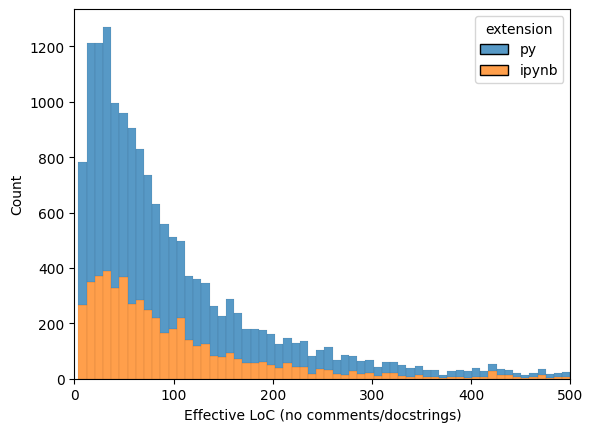

In [10]:
# plot line of code distribution
sns.histplot(
    data=df_filtered_on_content,
    x='loc',
    hue='extension',
    multiple='stack',
)
plt.xlim(0, 500)
plt.xlabel('Effective LoC (no comments/docstrings)')
# average line of code
print(f"Average line of code: {df_filtered_on_content['loc'].mean()}")
# total number of lines of code
print(f"Total number of lines of code: {df_filtered_on_content['loc'].sum()}")
perc_ipynb = ((len(df_filtered_on_content[df_filtered_on_content['extension'] == 'ipynb'])) / len(df_filtered_on_content)) * 100
print(f"Percentage of ipynb files: {perc_ipynb:.1f}%")

# Side: how many people leaked their API keys?

In [57]:
import re

# check how many files leaked the token key. e.g., they contain IBMQ.enable_account('
df_content_selection['leaked_token'] = df_content_selection['file_content_code_only'].str.contains(
    "IBMQ\.enable_account\('")

n_leaks = 0
for i, row in df_content_selection[df_content_selection['leaked_token']].iterrows():
    code = row['file_content_code_only']
    lines = code.splitlines()
    token_line = [l for l in lines if "IBMQ.enable_account('" in l]
    #print(token_line)
    #print(code)
    match = re.search(r"IBMQ\.enable_account\('([0-9a-zA-Z]*)'\)", token_line[0])
    if match:
        token = match.group(1)
        if len(token) == 128:
            print("=" * 80)
            print(row['output_file_name'])
            print(token[:10] + '...')
            n_leaks += 1
print(f"Number of leaks: {n_leaks}")

gen_algr_3qubits_d0fffa.py
ed1f707091...
views_5b7b88.py
fec810ec80...
train_pl_torch_vqe_623218.py
cfc6a18e1d...
Task%202,%20Q3_e13f19.py
7a14c59cb5...
weigthed_ssvqe_real_hardware_c85447.ipynb
4cd532424f...
shors_algorithm_3600ff.py
ea6beeda1e...
Shors_qiskit_a1da63.py
5732cdb162...
qiskit_shors2_9fd81d.py
99c0e0cf08...
QKE_PennyLane_9d3b9c.py
a38fb08449...
qiskit_shors_549107.py
99c0e0cf08...
err_10214c.py
c13b54ef03...
views_a79928.py
1689c0f13c...
Task%202%20Q4_b4970b.py
7a14c59cb5...
backends_e17d05.py
02c89fe68a...
qtrng_d03220.py
083bf4a193...
Grover4Qubit_2e182b.py
f449711b0c...
Untitled_0c291a.ipynb
9f7c61e6f3...
Gates_baec2f.ipynb
d08a710100...
openCVconvert_02707f.py
dd8c461ba8...
ibmq_parallel_5e5794.py
cfc6a18e1d...
QKE_PennyLane_db0080.py
a38fb08449...
Get%20System%20Properties_8bb519.py
51057eaa66...
%E9%87%8F%E5%AD%90%E9%BB%91%E5%AE%A2%E6%9D%BE_f87f6e.ipynb
d85090f46a...
Assignment3_b95100.ipynb
a19585690b...
gen_algr_20c5be.py
ed1f707091...
fs_batchrun_829105.py
f0f61

100%|██████████| 41297/41297 [00:00<00:00, 2788033.74it/s]


# Inspect a Sample of Data

In [27]:
SAMPLE_SIZE = 20
MAX_LINES_TO_SHOW = 15

df_sample = df_filtered_on_content.sample(n=SAMPLE_SIZE, random_state=88)

all_non_comment_lines = []

for i, row in df_sample.iterrows():
    program_name = row['unique_id'] + "." + row['extension']
    #content = row['file_content']
    content = row['file_content_code_only']
    print("=" * 80)
    print(program_name)
    print(row['download_url'])
    #content = simple_file_read(os.path.join(PROGRAMS_FOLDER, program_name))
    all_lines = content.splitlines()
    non_comment_lines = [
        line for line in all_lines 
        if not line.lstrip().startswith('#')]
    all_non_comment_lines += non_comment_lines
    n_lines = len(all_lines)
    print(f"Number of lines: {n_lines}")
    print("-" * 80)
    if n_lines > MAX_LINES_TO_SHOW:
        all_lines = all_lines[:MAX_LINES_TO_SHOW]
    shortened_content = '\n'.join(all_lines)
    print(shortened_content)
    if n_lines > MAX_LINES_TO_SHOW:
        print("...")

# remove empty lines
all_non_comment_lines = [line for line in all_non_comment_lines if line.strip()]
avg_lines_per_program = float(len(all_non_comment_lines)) / SAMPLE_SIZE
print(f"Average number of non-comment lines per program: {avg_lines_per_program}")

2-fitters-lookup_8278f1.ipynb
https://raw.githubusercontent.com/yaleqc/qtcodes/5f85ac7ba152dab5ec2884c6f2812fdb2c5e387a/tutorials/rep/2-fitters-lookup.ipynb
Number of lines: 49
--------------------------------------------------------------------------------
from qtcodes import RotatedDecoder
from qtcodes import RepetitionQubit
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors import pauli_error, depolarizing_error
from qiskit import execute, Aer


def get_noise_model(p_err):
    error_gate1 = pauli_error([('X', p_err / 2), ('Z', p_err / 2), ('I', 1 -
        p_err)])
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_gate1, 'id')
    return noise_model


...
LabExercise1_7c3a75.ipynb
https://raw.githubusercontent.com/MarkSaulAmbrose/ELEN4022_QuantumComputing_LabEx1/7e69b55178b8b14b40c13fceb39da4a6278dca45/LabExercise1.ipynb
Number of lines: 13
---------------------------------------------------------------------------

# Create Dataset of Filtered Programs (code only)
We store them without comments to apply the Allamanis de-duplication tool.

In [12]:
n_to_save = len(df_filtered_on_content)
print(f"Number of programs to save: {n_to_save}")

Number of programs to save: 16385


In [29]:
from tqdm import tqdm

for i, row in tqdm(df_filtered_on_content.iterrows()):
    # save the file in the programs folder
    # they are all python code since there is no scaffold for ipynb anymore
    program_name = row['unique_id'] + ".py"
    content = row['file_content_code_only']
    with open(os.path.join(FILTERED_PROGRAMS_FOLDER, program_name), 'w') as f:
        f.write(content)
        f.close()
    

16385it [01:06, 247.89it/s]


In [21]:
# df = df_filtered_on_content
# filter_id = '2020-12-13_catstate_grover_061089'
# code = df[df['unique_id'] == filter_id]['file_content_code_only'].values[0]
# print(code)

In [22]:
# code = read_ipynb(os.path.join(PROGRAMS_FOLDER, '2020-12-13_catstate_grover_061089.ipynb'))
# transformed_code = remove_docstrings(code)
# # parsed = ast.parse(code)
# # reconstructed_code = astor.to_source(parsed)
# print(transformed_code)

# Run De-Duplication Tool

In [31]:
# (venv38) :~/projects/qlint$ python qlint/datautils/tokenizer/tokenizepythoncorpus.py data/03_program_filtered/exp_v01/ data/03_program_filtered/exp_v01/tokenized_files/
# Tokenizing in folder data/03_program_filtered/exp_v01/code_only_programs.
# Tokenizing in folder data/03_program_filtered/exp_v01/tokenized_files.
# (venv38) :~/projects/qlint$ python qlint/datautils/pythonDedup/deduplicationcli.py data/03_program_filtered/exp_v01/tokenized_files/ dedup.json.gz
# Loading files: 100%|███████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.20s/it]
# Added files. Computing duplicates...
# Duplicated files: 32.58%
# Avg num of files per clones 3.19
# Median num of files per clones 2.0
# Duplication Ratio 22.37%
# Done.
# (venv38) :~/projects/qlint$ gzip -d dedup.json.gz

# De-Duplicated Dataset
After having run the Allamanis tool on the previous dataset, read the output of the tool to obtain the list of all near-duplicate files to remove.

In [13]:
dedup_dict = json.load(open(PATH_TO_DEDUP_DICT, 'r'))
list_of_duplicate_file_paths = [item for sublist in dedup_dict for item in sublist]
print(f"Number of duplicates: {len(list_of_duplicate_file_paths)}")

Number of duplicates: 5232


# Create new Dataset of Programs (code only)

In [14]:

# move the selected programs to a new folder
all_ids = df_filtered_on_content['unique_id'].values
ids_of_duplicates = [os.path.splitext(os.path.basename(path))[0] for path in list_of_duplicate_file_paths]
ids_legit_programs = [id for id in all_ids if id not in ids_of_duplicates]
print(f"Number of legit programs: {len(ids_legit_programs)}")


Number of legit programs: 11153


In [ ]:
import shutil
# copy legit programs to code_only_programs folder to program_under_study folder
for id in tqdm(ids_legit_programs):
    src = os.path.join(FILTERED_PROGRAMS_FOLDER, id + ".py")
    dst = os.path.join(DIR_FINAL_DATASET, id + ".py")
    shutil.copyfile(src, dst)

In [15]:
df_legit_df = df_filtered_on_content[
    df_filtered_on_content['unique_id'].isin(ids_legit_programs)]
df_legit_df.to_csv(PATH_COMPRESSED_FINAL_DATASET, index=False)

Number of programs: 16385
Number of programs after removing duplicates: 11153
Remove files without QuantumCircuit >> 6061
Number of programs selected: 6061


/home/paltenmo/projects/qlint/venv38/lib/python3.8/site-packages/seaborn/distributions.py:269: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  baselines.iloc[:, cols] = (curves


Average line of code: 136.3842600230985
Total number of lines of code: 826625
Percentage of ipynb files: 31.3%


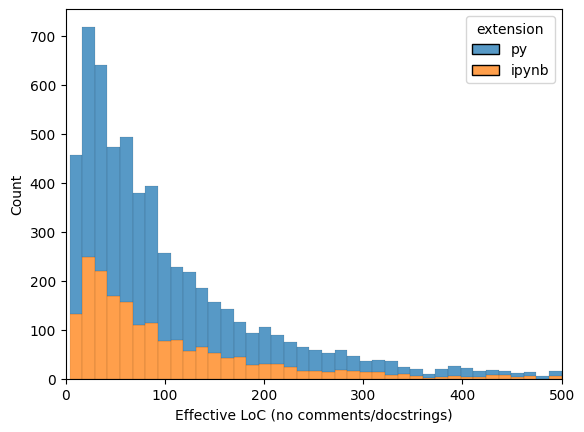

In [55]:
df = df_filtered_on_content.copy()
print(f"Number of programs: {len(df)}")

# remove duplicates
df = df[~df['unique_id'].isin(ids_of_duplicates)]
print(f"Number of programs after removing duplicates: {len(df)}")

# the programs must contain QuantumCircuit(
df = df[df['file_content_code_only'].str.contains('QuantumCircuit\(')]
print(f'Remove files without QuantumCircuit >> {len(df)}')

ids_selected = df['unique_id'].values
print(f"Number of programs selected: {len(ids_selected)}")

# plot line of code distribution
sns.histplot(
    data=df,
    x='loc',
    hue='extension',
    multiple='stack',
)
plt.xlim(0, 500)
plt.xlabel('Effective LoC (no comments/docstrings)')
# average line of code
print(f"Average line of code: {df['loc'].mean()}")
# total number of lines of code
print(f"Total number of lines of code: {df['loc'].sum()}")
perc_ipynb = ((len(df[df['extension'] == 'ipynb'])) / len(df) )* 100
print(f"Percentage of ipynb files: {perc_ipynb:.1f}%")

# Copy the Selected One for Further Analysis

In [ ]:
# copy them to the directory with circuit
for id in ids_selected:
    src = os.path.join(DIR_FINAL_DATASET, id + ".py")
    dst = os.path.join(DIR_W_CIRCUIT, id + ".py")
    shutil.copyfile(src, dst)